![title](sztaki_logo_angol_kek.png)

### Neural Network Example

Build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow.

This example is using some of TensorFlow higher-level wrappers (tf.estimators, tf.layers, tf.metrics)

### Diasble warnings

In [150]:
import warnings
warnings.filterwarnings('ignore')

### Import python dependencies

In [151]:
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

### Check whether if you have CPU or GPU capable Virtual Machine

In [152]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16733645962380706499
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15145022821732302971
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 478228289188116904
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9598495104808129008
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:05.0, compute capability: 3.7"
]


### MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![title](mnist1.png)

### Import MNIST dataset

In [153]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Set most important parameters for learning

In [154]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

### Define the input funcitons for training

In [155]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

### Define the neural network (Multi Layer Perceptron)

In [156]:
def neural_net(x_dict):

    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']

    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)

    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)

    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)

    return out_layer

![title](mnist3.png)

### Define the model function (following TF Estimator Template)

In [157]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

### Build or Compile the TensorFlow model

In [158]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbc2jpnsm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0463c05390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train the Neural Network

In [159]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbc2jpnsm/model.ckpt.
INFO:tensorflow:loss = 2.421718, step = 0
INFO:tensorflow:global_step/sec: 271.133
INFO:tensorflow:loss = 0.41790494, step = 100 (0.371 sec)
INFO:tensorflow:global_step/sec: 335.584
INFO:tensorflow:loss = 0.39016563, step = 200 (0.298 sec)
INFO:tensorflow:global_step/sec: 325.933
INFO:tensorflow:loss = 0.2945627, step = 300 (0.307 sec)
INFO:tensorflow:global_step/sec: 326.498
INFO:tensorflow:loss = 0.21434724, step = 400 (0.310 sec)
INFO:tensorflow:global_step/sec: 317.854
INFO:tensorflow:loss = 0.40531886, step = 500 (0.313 sec)
INFO:tensorflow:global_step/sec: 289.331
INFO:tensorflow:loss = 0.30905372, step = 600 (0.343 sec)
INFO:tensorflow:global_step/sec: 362.617
INFO:tensorf

![title](mnist4.png)

### Evaluate the model, measure the accuracy

In [160]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)

# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-24T15:14:31Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbc2jpnsm/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-24-15:14:31
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9108, global_step = 1000, loss = 0.30457884
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpbc2jpnsm/model.ckpt-1000


{'accuracy': 0.9108, 'loss': 0.30457884, 'global_step': 1000}

We can see the accuracy is around 0.91 which means 91%

### Predict all of the test images

In [161]:
n_images = len(mnist.test.labels)

# Get images from test set
test_images = mnist.test.images[:n_images]

# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)

# Use the model to predict the images class
preds = list(model.predict(input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbc2jpnsm/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Define a helper function which helps us to show confusion matrix

In [162]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### This is a helper variable

In [163]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']

### Create Confusion Matrix

Input one is the predicted value, input two is the ground thruth value. Now we can compare the predicted values with the ground thruth values

In [164]:
cm = confusion_matrix(mnist.test.labels, preds)

### Plot the Confusion Matrix

Confusion matrix, without normalization
[[ 960    0    2    2    0    8    1    4    3    0]
 [   0 1122    1    3    0    1    3    2    3    0]
 [  13   26  862   25   11    6   12   18   53    6]
 [   4    1    9  928    0   22    1   18   21    6]
 [   2    6    5    3  913    0    6    3    8   36]
 [   8    6    1   40   11  765   13   11   32    5]
 [  21    3    5    2   29   18  871    3    6    0]
 [   3   10   15    6    6    1    0  971    1   15]
 [   6   19    4   27   10   30    8   19  848    3]
 [  12    8    1   11   39    7    0   56    7  868]]


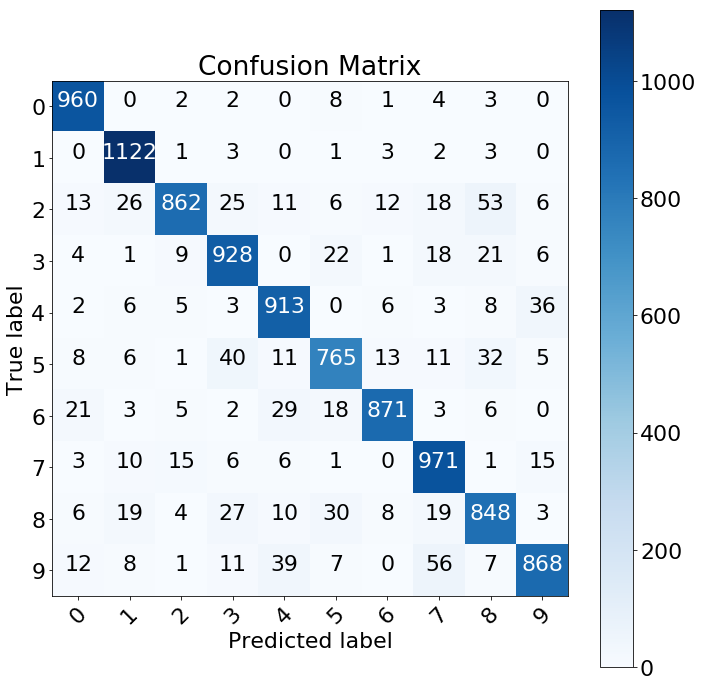

In [165]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Show some predictions vs ground thruth picture

Under the picture you can see the predicted value

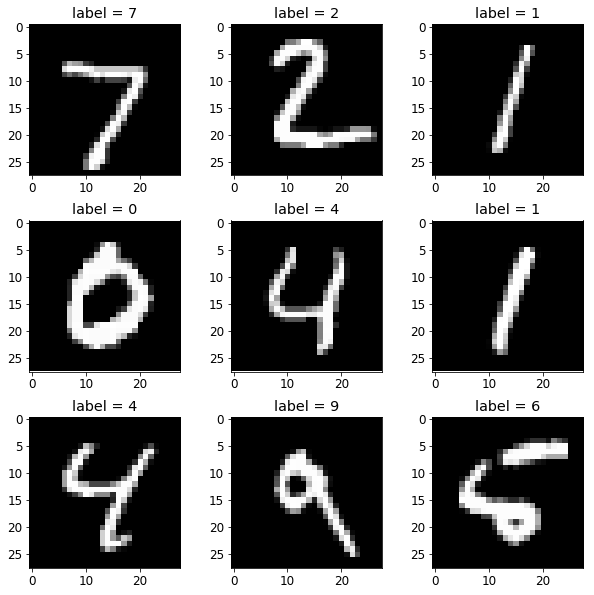

In [166]:
# Get first 9 images from test set
test_images = mnist.test.images[:9]

plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(np.reshape(test_images[i],(28,28)),cmap='gray')
    plt.title('label = ' + str(preds[i]))